In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import os
import matplotlib.pyplot as plt
import time

In [2]:
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=float,skip_header=1)

#### Read the train and test data

In [3]:
trainX = csv_to_numpy_array("prod_centricity/trainX.csv", delimiter=",")
trainY = csv_to_numpy_array("prod_centricity/trainY.csv", delimiter=",")
testX = csv_to_numpy_array("prod_centricity/testX.csv", delimiter=",")
testY = csv_to_numpy_array("prod_centricity/testY.csv", delimiter=",")

In [4]:
#########################
### GLOBAL PARAMETERS ###
#########################

# DATA SET PARAMETERS
# Get our dimensions for our different variables and placeholders:
# numFeatures = the number of words extracted from each email
numFeatures = 4 #trainX.shape[1]
# numLabels = number of classes we are predicting (here just 2: Ham or Spam)
numLabels = trainY.shape[1]

# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [5]:
####################
### PLACEHOLDERS ###
####################

# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [6]:
#################
### VARIABLES ###
#################

# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [7]:
######################
### PREDICTION OPS ###
######################

# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

In [8]:
#####################
### EVALUATION OP ###
#####################

# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")
cost_OP1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(add_bias_OP,yGold))

In [9]:
#######################
### OPTIMIZATION OP ###
#######################

# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

step 0, training accuracy 0.270142
step 0, cost 96.8647
step 0, change in cost 96.8647
step 10, training accuracy 0.459716
step 10, cost 79.9514
step 10, change in cost 16.9133
step 20, training accuracy 0.464455
step 20, cost 77.043
step 20, change in cost 2.90842
step 30, training accuracy 0.469194
step 30, cost 74.5681
step 30, change in cost 2.47488
step 40, training accuracy 0.478673
step 40, cost 72.4668
step 40, change in cost 2.10131
step 50, training accuracy 0.483412
step 50, cost 70.7135
step 50, change in cost 1.75333
step 60, training accuracy 0.488152
step 60, cost 69.2601
step 60, change in cost 1.45343
step 70, training accuracy 0.49763
step 70, cost 68.0427
step 70, change in cost 1.2174
step 80, training accuracy 0.50237
step 80, cost 66.9908
step 80, change in cost 1.0519
step 90, training accuracy 0.50237
step 90, cost 66.0308
step 90, change in cost 0.95993
step 100, training accuracy 0.50237
step 100, cost 65.082
step 100, change in cost 0.948837
step 110, trainin

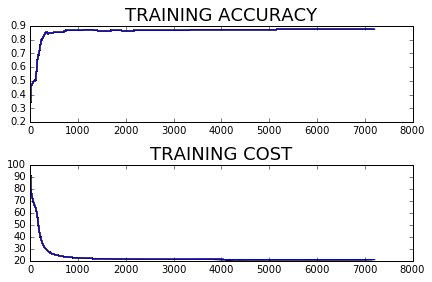

In [10]:
###########################
### GRAPH LIVE UPDATING ###
###########################

epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph_def)



# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP,cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            #time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

In [86]:
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

final accuracy on test set: 0.867925


In [12]:
weights

In [13]:
sess.run(bias)

array([[-6.29393435,  6.39006042]], dtype=float32)

In [33]:
#get probability value for a given input.
x1=np.array([[0.0,0.0,0.2,0.1]])
y1=np.array([[1,0]])
sess.run(activation_OP,feed_dict={X:x1})

array([[ 0.00194525,  0.98826116]], dtype=float32)

In [17]:
x1.shape

(1, 4)

In [18]:
testX.shape

(53, 4)

In [19]:
trainX.shape

(211, 4)

In [20]:
trainY.shape

(211, 2)

In [21]:
sess.run(tf.nn.softmax_cross_entropy_with_logits(add_bias_OP,yGold),feed_dict={X:x1,yGold:y1})

array([ 0.09746567], dtype=float32)

In [22]:
sess.run(tf.nn.sigmoid(10.0))

0.99995458

In [23]:
sess.run(cost_OP,feed_dict={X:x1,yGold:y1})

0.060847588

In [40]:
sess.run(cost_OP1,feed_dict={X:testX,yGold:testY})

0.53249544

In [11]:
accuracy_values

[0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.49289098,
 0.5687204,
 0.63033175,
 0.72037917,
 0.74407583,
 0.79146922,
 0.83412319,
 0.84834123,
 0.85308057,
 0.85781991,
 0.85781991,
 0.85781991]

In [12]:
cost_values

[5.4447966,
 5.0179462,
 4.7105241,
 4.3523402,
 4.004334,
 3.7014742,
 3.4462745,
 3.2194164,
 2.9931815,
 2.7364919,
 2.3938942,
 1.7644708,
 0.74838257,
 0.67568296,
 0.60561264,
 0.54509306,
 0.49430948,
 0.45201296,
 0.43114838,
 0.42073059,
 0.41593388,
 0.41424325,
 0.41416937]

In [13]:
epoch_values

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220]

In [15]:
%matplotlib inline
plt.figure()
plt.plot(epoch_values,cost_values)
plt.show()

In [78]:
from sklearn.metrics import roc_curve,auc,accuracy_score

In [46]:
score=sess.run(activation_OP,feed_dict={X:testX})
score_pred = [b[1] for b in score]
actual = [b[1] for b in testY]
fpr,tpr,thresholds = roc_curve(actual,score_pred)
roc_auc = auc(fpr,tpr)

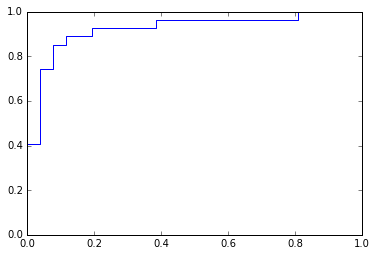

In [33]:
plt.plot(fpr,tpr)

In [36]:
roc_auc

0.92307692307692313

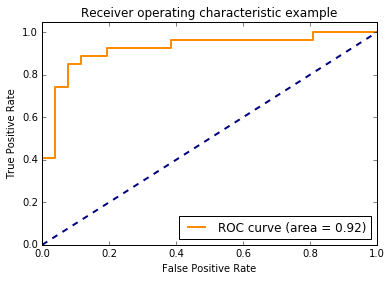

In [40]:
plt.plot(fpr,tpr,color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [41]:
len(tpr)

15

In [42]:
tpr

array([ 0.03703704,  0.40740741,  0.40740741,  0.74074074,  0.74074074,
        0.85185185,  0.85185185,  0.88888889,  0.88888889,  0.92592593,
        0.92592593,  0.96296296,  0.96296296,  1.        ,  1.        ])

In [43]:
fpr

array([ 0.        ,  0.        ,  0.03846154,  0.03846154,  0.07692308,
        0.07692308,  0.11538462,  0.11538462,  0.19230769,  0.19230769,
        0.38461538,  0.38461538,  0.80769231,  0.80769231,  1.        ])

In [44]:
len(fpr)

15

In [47]:
thresholds

array([  9.90558624e-01,   9.11436081e-01,   8.86400938e-01,
         7.69172072e-01,   7.62400866e-01,   5.97232044e-01,
         5.89095771e-01,   4.91873413e-01,   4.15975571e-01,
         3.84383053e-01,   2.35399887e-01,   1.31808177e-01,
         5.21235634e-03,   2.64048972e-03,   3.51882009e-05], dtype=float32)

In [53]:
thresholds[9]

0.38438305

In [52]:
tpr[9],fpr[9]

(0.92592592592592593, 0.19230769230769232)

score=sess.run(activation_OP,feed_dict={X:trainX})
score_pred = [b[1] for b in score]
actual = [b[1] for b in trainY]
fpr,tpr,thresholds = roc_curve(actual,score_pred)
roc_auc = auc(fpr,tpr)# lets try ROC on training data

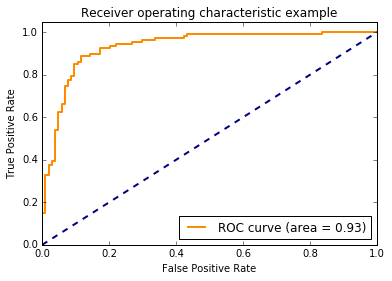

In [54]:
score=sess.run(activation_OP,feed_dict={X:trainX})
score_pred = [b[1] for b in score]
actual = [b[1] for b in trainY]
fpr,tpr,thresholds = roc_curve(actual,score_pred)
roc_auc = auc(fpr,tpr)# lets try ROC on training data

plt.plot(fpr,tpr,color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [91]:
def pred(x,threshold):
    if x >= threshold :
        return 1;
    else:
        return 0;

In [92]:
pred = [pred(i,0.39) for i in score_pred]

In [93]:
accuracy_score(actual,pred)

0.86255924170616116

In [80]:
thresholds

array([  9.90789533e-01,   9.57410991e-01,   9.56822932e-01,
         9.18812990e-01,   9.18606281e-01,   9.04708445e-01,
         9.04326439e-01,   8.91598701e-01,   8.87227356e-01,
         8.58119071e-01,   8.57847989e-01,   8.22800636e-01,
         8.22089911e-01,   8.12487364e-01,   8.11531723e-01,
         7.55397260e-01,   7.47315526e-01,   7.36158192e-01,
         7.27279544e-01,   7.06188619e-01,   6.89285755e-01,
         6.68463409e-01,   6.58181131e-01,   6.55458391e-01,
         6.51911497e-01,   6.29335999e-01,   5.99199831e-01,
         5.90839982e-01,   5.58441043e-01,   5.04830062e-01,
         4.49685037e-01,   4.23222423e-01,   3.78207654e-01,
         3.73239547e-01,   2.02710629e-01,   1.66968077e-01,
         1.28060877e-01,   1.17892981e-01,   7.65089616e-02,
         7.18089193e-02,   5.42636886e-02,   4.96369600e-02,
         4.76536974e-02,   4.66688350e-02,   2.76231120e-04,
         2.62755377e-04,   1.60164582e-05], dtype=float32)